### Train a UNet Model for image segmentation using fast ai 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import carla_extension.conversions as conversions

In [3]:
dir_dataset = Path("./dataset")
dir_images = dir_dataset/"images"
dir_labels = dir_dataset/"labels"

In [ ]:
# The labels have the same name as the images, but they are stored in the labels folder
get_y_fn = lambda x: dir_labels/f'{x.stem}{x.suffix}'

### View some examples

We can see something significant her. We have two segmentation masks which are displayed with different colour maps. We should inspect this further!!!

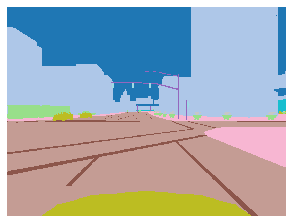

In [5]:
fnames = get_image_files(dir_images)
img_f = fnames[2]
example_mask1 = open_mask(get_y_fn(img_f))
example_mask1.show(figsize=(5,5), alpha=1)

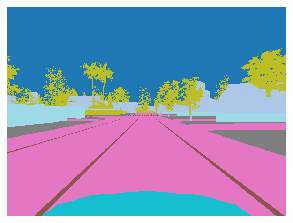

In [6]:
img_f = fnames[100]
example_mask2 = open_mask(get_y_fn(img_f))
example_mask2.show(figsize=(5,5), alpha=1)

When we look at the values within the mask arrays, we can see that despite the fact that the segmentation masks are displayed differently, they are actually using the same codes. For "example_mask1" we see the code for road(7), car(10), road line(6) and then road(7) again. For "example_mask2" we see the code for road(7), road line(6), car(10), road line(6) and then road(7) again. That means that our data is actually not corrupted.

In [7]:
example_mask1.data[0,-1,:]

tensor([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 

In [8]:
example_mask2.data[0,-1,:]

tensor([ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 

In [9]:
# Create a databunch using the data_block api
data = (
    # take the data from the image subfolder
    SegmentationItemList.from_folder(dir_images)
    # use the valid.txt to find the validation set
    .split_by_fname_file("../valid.txt")
    # use the get_y_fn to find the filenames for the correct image labels
    .label_from_func(get_y_fn, classes=conversions.image_segmentation_mask_to_labels)
    # set transformations
    .transform(get_transforms(), tfm_y=True, size=128)
    # create the databunch with a batch size of bs
    .databunch(bs=2)
    # normalize the data
    .normalize(imagenet_stats)
)

In [12]:
# create a custom metric
# we want to exclude all unlabeled pixels from the evaluation
unlabeled_code = conversions.labels_to_image_segmentation_mask['Unlabeled']

def acc_carla(src, target):
    target = target.squeeze(1)
    mask = target != unlabeled_code
    return (src.argmax(dim=1)[mask]==target[mask]).float().mean()

In [13]:
# create the model
learn = unet_learner(data, models.resnet34, metrics=acc_carla, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


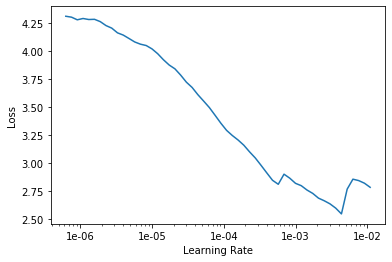

In [14]:
lr_find(learn)
learn.recorder.plot()

In [15]:
lr=8e-4

In [16]:
# train
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_carla,time
0,0.384024,0.409997,0.833748,02:03
1,0.301826,0.329554,0.876945,01:59
2,0.288079,0.335756,0.856638,02:07
3,0.252983,0.278847,0.886892,02:05
4,0.286352,0.280488,0.890807,01:56
5,0.267935,0.275464,0.885516,01:58
6,0.250430,0.279251,0.892553,01:58
7,0.232596,0.285188,0.902217,01:59
8,0.236359,0.268147,0.894641,01:58
9,0.183116,0.205135,0.920283,02:01


In [19]:
learn.save('stage-1')

In [20]:
learn.load('stage-1');

In [22]:
# fine tuning
learn.unfreeze()
lrs = slice(lr/400,lr/4)

In [23]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_carla,time
0,0.173976,0.205098,0.917896,02:14
1,0.163899,0.200468,0.920632,02:12
2,0.183924,0.197957,0.921699,02:14
3,0.172542,0.195169,0.922056,02:16
4,0.183785,0.194489,0.924045,02:17
5,0.188405,0.200247,0.924287,02:16
6,0.155644,0.203799,0.927201,02:15
7,0.164477,0.196564,0.925154,02:17
8,0.153437,0.192537,0.925151,02:18
9,0.149813,0.192015,0.926268,02:18


In [24]:
learn.save('stage-2');

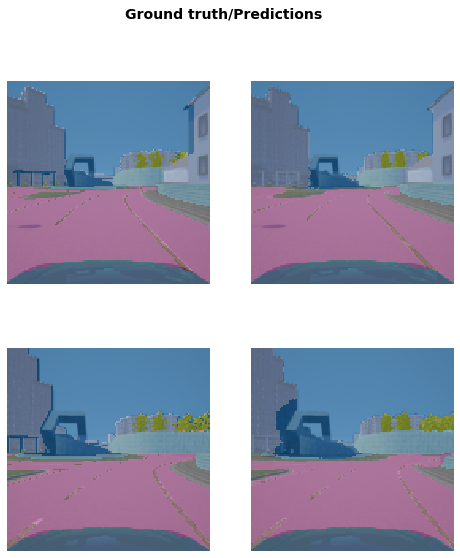

In [25]:
learn.show_results(rows=3, figsize=(8,9))

### Upgrade the UNet to handle greater images

In [26]:
data = (SegmentationItemList.from_folder(dir_images)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_fname_file("../valid.txt")
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=conversions.image_segmentation_mask_to_labels)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=224)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=2)
        .normalize(imagenet_stats))
        #Finally -> use the defaults for conversion to databunch

In [27]:
learn = unet_learner(data, models.resnet34, metrics=acc_carla, wd=1e-2)

In [28]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


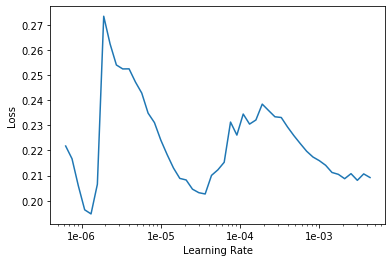

In [29]:
lr_find(learn)
learn.recorder.plot()

In [30]:
lr=1e-5

In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_carla,time
0,0.195238,0.208752,0.922164,02:19
1,0.175386,0.202655,0.924700,02:14
2,0.164421,0.198869,0.926610,02:16
3,0.188325,0.196738,0.927220,02:14
4,0.184378,0.195247,0.927261,02:15
5,0.152555,0.194732,0.927314,02:14
6,0.176962,0.188940,0.928444,02:14
7,0.199742,0.188705,0.928006,02:14
8,0.164201,0.191811,0.928153,02:13
9,0.160533,0.190422,0.928187,02:14


In [32]:
learn.save('stage-1-big')

In [33]:
learn.load('stage-1-big');

In [38]:
learn.unfreeze()

In [39]:
lrs = slice(1e-6,lr/10)

In [40]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_carla,time
0,0.149948,0.192847,0.926954,02:33
1,0.168312,0.188770,0.928945,02:34
2,0.170460,0.187326,0.928870,02:36
3,0.165791,0.188677,0.928985,02:34
4,0.159453,0.185944,0.930067,02:32
5,0.157136,0.187663,0.928732,02:33
6,0.172956,0.186037,0.929899,02:36
7,0.158760,0.186971,0.930102,02:36
8,0.157223,0.186984,0.930035,02:34
9,0.170427,0.187558,0.929244,02:34


In [43]:
learn.save('stage-2-big')

In [44]:
learn.export()

### Playing around with the trained model

In [45]:
learn.load('stage-2-big');

In [46]:
learn = load_learner(dir_images)

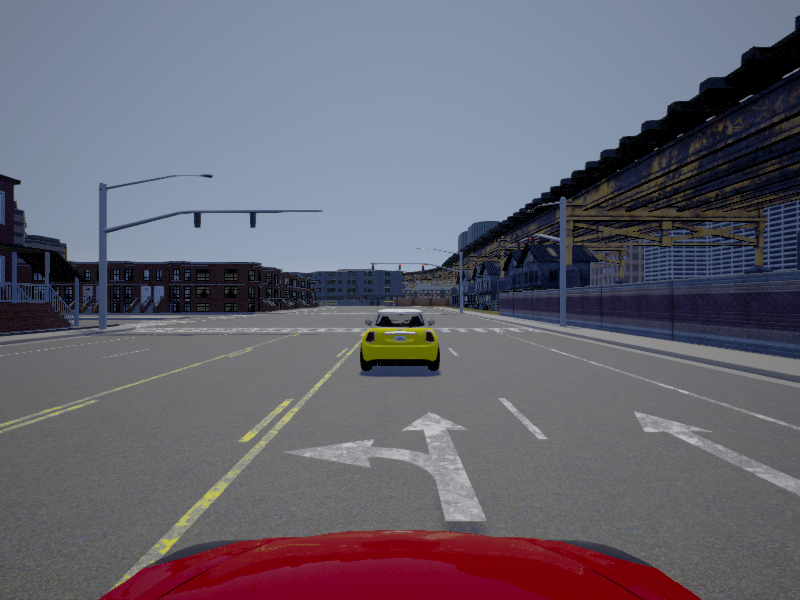

In [53]:
img = open_image(dir_images/"run6_fr_1610.png")
img

In [54]:
mask, _, _ = learn.predict(img)

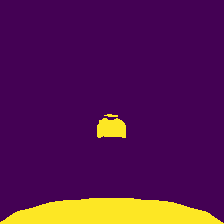

In [58]:
# filter all cars
car_filter = mask.data == conversions.labels_to_image_segmentation_mask["Car"]
ImageSegment(mask.data * car_filter)

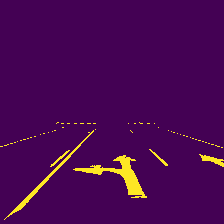

In [60]:
# filter all road lines
road_line_filter = mask.data == conversions.labels_to_image_segmentation_mask["Road line"]
ImageSegment(mask.data * road_line_filter)